## Microbenchmarks - Summary

Adapted from https://github.com/TheSalon/fast-dpsgd/blob/main/results/runtimes.ipynb

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 200)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
RAW = 'raw'
RUNS = 100
REPEATS = 25

# if you change this please also change all other full-length graphs to the exact same FIGSIZE 
FIGSIZE = (10, 5)

In [4]:
layers = ['mha', 'rnn', 'gru', 'lstm']
norms = {
    'layernorm': 'LayerNorm',
    'instancenorm': 'InstanceNorm',
    'groupnorm': 'GroupNorm',
}

filenames = ['conv'] + list(norms.keys()) + ['linear', 'embedding'] + layers
gsm_filenames = ['gsm_' + name if name not in layers else 'gsm_dp' + name for name in filenames]

def prettify(name):
    if name in layers: return name.upper()
    elif name in norms: return norms[name]
    else: return name.capitalize()
    
layer_names = [prettify(name) for name in filenames]
assert(len(filenames) == len(gsm_filenames) == len(layer_names))

batch_sizes = [16, 32, 64, 128, 256, 512]

In [5]:
def generate_df(names, pnames):
    
    def expt_iterator(names):
        for name, pname in zip(names, pnames):
            for bs in batch_sizes:
                yield name, pname, bs

    files, success, errors = [], [], []
    
    for name, pname, bs in expt_iterator(names):
        pickle_name = f'./{RAW}/{name}_bs_{bs}_runs_{RUNS}_repeats_{REPEATS}'
        try:
            with open(pickle_name+'.pkl', 'rb') as f:
                d = pickle.load(f)
                assert(len(d['runtime']) == RUNS)
                assert(len(d['memory']) == RUNS)
            files.append((name, pname, bs, d))
            success.append(pickle_name)
            
        except:
            errors.append(pickle_name)
    
    assert len(errors) == 0
    
    df_list = []
    for *row, d in files:
        # d['memory'] = (base_memory, max_memory)
        mem = [m-b for b, m in d['memory']]
        d = [np.median(d['runtime']),  np.median(mem)]
        df_list.append(pd.Series(row + d))

    df = pd.concat(df_list, axis=1).transpose()
    df.columns = ['File', 'Layer', 'Batch Size', 'Median Runtime', 'Median Memory']
    return df

In [6]:
nn = generate_df(filenames, layer_names)
opacus = generate_df(gsm_filenames, layer_names) 

df = nn[['File', 'Layer', 'Batch Size']].copy()
df['Median Runtime'] =  opacus['Median Runtime'] / nn['Median Runtime'] 
df['Median Memory'] =  opacus['Median Memory'] / nn['Median Memory'] 

In [7]:
df['Order'] = -1
for i,name in enumerate(filenames):
    df.loc[df['File'] == name, 'Order'] = i
    
assert not (df['Order'] == -1).sum()
df = df.sort_values(by=['Batch Size', 'Order'])

In [8]:
# throw out the first and last color as too light/dark
count = len(pd.unique(df['Batch Size']))
PALETTE = sns.color_palette(palette='Blues', n_colors=count+2, desat=None, as_cmap=False)
PALETTE = PALETTE[1:-1]

def get_runtime_plot(ax, item, ylim=None, figsize=(13, 6)): 
    sns.set_style("whitegrid")
    
    plot_df = df.copy()
    sns.barplot(
        x='Layer',
        y=f'Median {item}',
        hue='Batch Size',
        data=plot_df,
        ax=ax,
        palette=PALETTE
    )
    WIDTH = 0.15

    tmp = df[f'Median {item}']
    for i, (rect, tim) in enumerate(zip(ax.patches, tmp)):
        
        # add space between bars
        width = rect.get_width()
        rect.set_width(width-(width*0.15))
        (x, y) = rect.get_xy()
        rect.set_xy((x + width*0.15, y))
        
        # annotate bars
        height = rect.get_height()
        width = rect.get_width()
        if tim > 100.:
            annotation = f'{int(tim)}'
        elif tim > 0.:
            annotation = f'{tim:.2g}'
        else:
            annotation = ''
        ax.annotate(
            annotation,
            xy=(
                rect.get_x() + width / 2 - 0.5*width, 
                min(height, ylim)
            ),
            xytext=(
                rect.get_x() + width / 2 - 0.5*width, 
                min(height + ylim/figsize[1]*0.08, ylim + ylim/figsize[1]*0.08)
            ),
            textcoords='data',
            va='bottom', ha='left', 
            fontsize=9, rotation=90
        )

    if item == 'Runtime':
        ax.set_ylabel('Runtime increase (factor)')
    else:
        ax.set_ylabel('Memory increase (factor)')
           
    ax.set_xlabel('Layer')
    if ylim:
        ax.set_ylim(0, ylim)
    sns.despine()
    ax.legend(loc='upper left')
    f.patch.set_facecolor('white')
    f.tight_layout()
    return f, ax

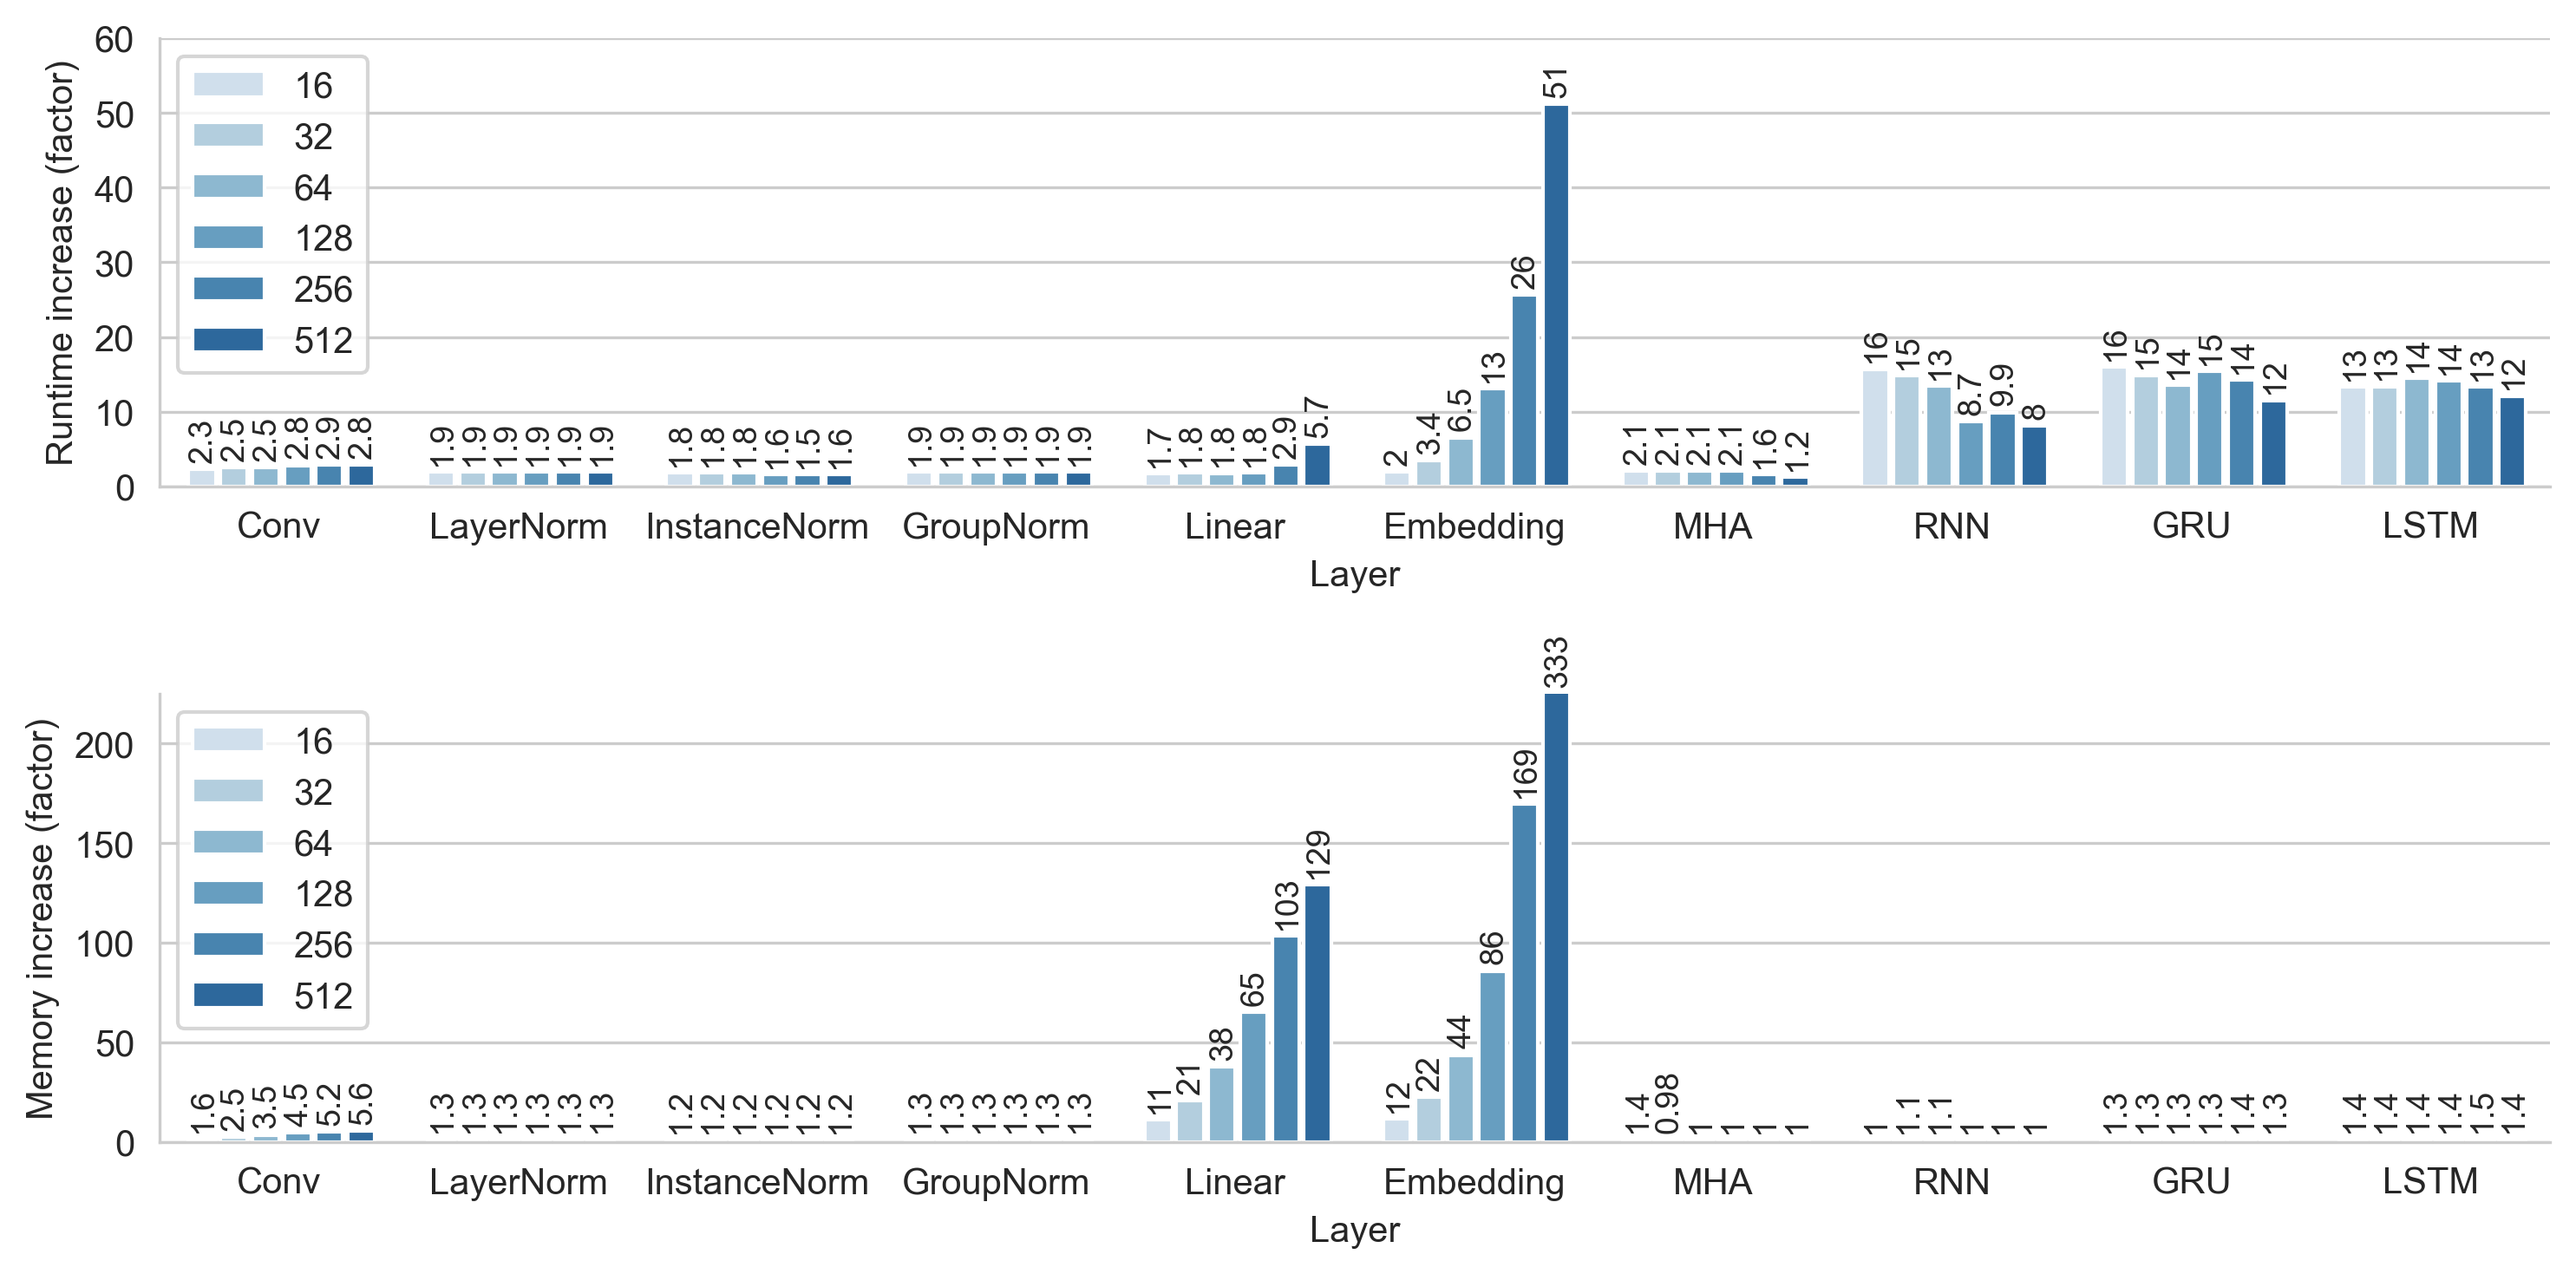

In [9]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'Runtime', 60, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'Memory', 225, figsize=FIGSIZE)
f.savefig('./figures/microbe.pdf')